In [1]:
import random
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import pandas_datareader.data as reader
import datetime as dt
import matplotlib.pyplot as plt
import getFamaFrenchFactors as gff
import seaborn as sns

## Three Factor Model (Fama-Fremch, 1993)

>$$R_{s}-R_{f}=\alpha+\beta_{mkt}\left(R_{mkt}-R_{f}\right)+\beta_{SMB}R_{SMB}+\beta_{HML}R_{HML}$$

where: <br>
$R_{s}-R_{f}$ = cost of equity <br>
$R_{s}$ = return on stock <br>
$R_{f}$ = risk-free rate <br>
$\beta_{mkt}$ = market beta <br>
$R_{mkt}$ = market premuim<br>
$\beta_{SMB}$ = size beta <br>
$R_{SMB}$ = size premuim<br>
$\beta_{HML}$ = value beta <br>
$R_{HML}$ = value premuim <br>

*Model was chosen instead of traditional CAPM due to the stock's low Beta.

Get monthly stock prices from Yahoo Finance

In [2]:
end = dt.datetime.now()
start = dt.date(end.year-11, end.month, end.day)
ticker= ['ENB.TO']
stock_prices = reader.get_data_yahoo(ticker, start, end)['Adj Close']
stock_prices = stock_prices.resample('1M').last()
stock_returns = stock_prices.pct_change()
stock_returns = stock_returns.dropna()

Get Monthly Fama-french 3 Factors from Kenneth R. French  data library

In [3]:
ff3_monthly = pd.DataFrame(gff.famaFrench3Factor(frequency='m'))
ff3_monthly.rename(columns={'date_ff_factors':'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace = True)
market_premium = ff3_monthly['Mkt-RF'].mean()
size_premium = ff3_monthly['SMB'].mean()
value_premium = ff3_monthly['HML'].mean()
print('Market Premium:',market_premium, 'Size Premium:', size_premium,'Value Premium:', value_premium)


Market Premium: 0.006642510822510826 Size Premium: 0.001931948051948053 Value Premium: 0.003523896103896111


Monthly Excess Returns

In [14]:
data= ff3_monthly.merge(stock_returns, on = 'Date')
data.head()
data = data.tail(60)
data.shape
excess_return = data['ENB.TO']-data['RF']
data['ENB.TO-RF']=excess_return
data.tail()



,Mkt-RF,SMB,HML,RF,ENB.TO,ENB.TO-RF
Date,,,,,,
2022-05-31,-0.0034,-0.0185,0.0841,0.0003,0.058515,0.058215
2022-06-30,-0.0843,0.0209,-0.0597,0.0006,-0.069656,-0.070256
2022-07-31,0.0957,0.0281,-0.0410,0.0008,0.057947,0.057147
2022-08-31,-0.0378,0.0139,0.0031,0.0019,-0.043710,-0.045610
2022-09-30,-0.0936,-0.0081,0.0005,0.0019,-0.054284,-0.056184


OLS Regression to Estimate Beta

*Mkt-RF is statistically significant (P>|t| < 5, t > 2) <br>
*HML is statistically significant (P>|t| < 5, t > 2)



In [15]:
X =  data[['Mkt-RF', 'SMB', 'HML']]
Y = data['ENB.TO-RF']

X1 = sm.add_constant(X)
model = sm.OLS(Y,X1)
results = model.fit()

intercept, beta_m, beta_s, beta_v = results.params
print('Market Beta:',beta_m, 'Size Beta:', beta_s, 'Value Beta', beta_v)
results.summary()



Market Beta: 0.5019586980923032 Size Beta: 0.2630988343641346 Value Beta 0.3843818448699845


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ENB.TO-RF   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     8.723
Date:                Sat, 05 Nov 2022   Prob (F-statistic):           7.69e-05
Time:                        02:43:21   Log-Likelihood:                 94.634
No. Observations:                  60   AIC:                            -181.3
Df Residuals:                      56   BIC:                            -172.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.007      0.480      0.633      -0.010       0.017
Mkt-RF         0.5020      0.130      3.853      0.000       0.241       0.763
SMB            0.2631      0.259      1.017      0.313      -0.255       0.781
HML            0.3844      0.157      2.448      0.018       0.070       0.699
==============================================================================
Omnibus:                        3.721   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.156   Jarque-Bera (JB):                2.792
Skew:                           0.402   Prob(JB):                        0.248
Kurtosis:                       3.686   Cond. No.                         39.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Calculate Cost of Equity

In [6]:
risk_free = data['RF'].mean()
risk_free
exp_return = risk_free + beta_m*market_premium + beta_s*size_premium + beta_v*value_premium
exp_return=exp_return*12 
print('Cost of Equity:',exp_return*100,'%')

Cost of Equity: 6.050418502530049 %


## Dividend Discount Model

>$$P=\frac{D_{1}}{r-g}  $$

where: <br>
$P$ = price <br>
$D_{1}$ = value of next year dividend <br>
$r$ = constant cost of equity capital <br>
$g$ = constant growth rate in perpetuity <br>


In [7]:
curr_price=stock_prices[ticker[0]][-1]
div = 3.24
cost_capital_mean = exp_return
cost_capital_std = 0.01
growth_mean= 0.02
growth_std= 0.01


def dividend_discount (dividend, cost_capital, growth):
    return dividend/(cost_capital-growth)

In [8]:
fair_price=dividend_discount(div, cost_capital_mean, growth_mean)
print('The Fair Price is $', fair_price)
print('Upside',((fair_price-curr_price)/curr_price)*100)


The Fair Price is $ 79.99173413750134
Upside 47.66796537083726


## Sensitivity Analysis - Monte Carlo Simulations

In [9]:
results = []
n_iterations=100000

def ddm_sim(div, cost_capital_mean, cost_capital_std, growth_mean, growth_std, n_iterations):
    for i in range(n_iterations):
        growth = random.normalvariate(growth_mean,growth_std)
        cost_capital = random.normalvariate(cost_capital_mean, cost_capital_std)
        if growth > (cost_capital-0.005):
            continue
        price=dividend_discount(div,cost_capital,growth)
        results.append((growth,cost_capital,price))               
    return results

def styled_df(df):
    return df.style.format({
        'Growth': '{:.2%}',
        'Cost of Capital': '{:.2%}',
        'Price' : '${:,.2f}'
            }).background_gradient(cmap='RdYlGn', subset='Price')

results = ddm_sim(div, cost_capital_mean,cost_capital_std, growth_mean, growth_std, n_iterations)
df = pd.DataFrame(results, columns=['Growth','Cost of Capital', 'Price'])


## Fair Price Distribution 
Log-normal distribution

<AxesSubplot:ylabel='Frequency'>

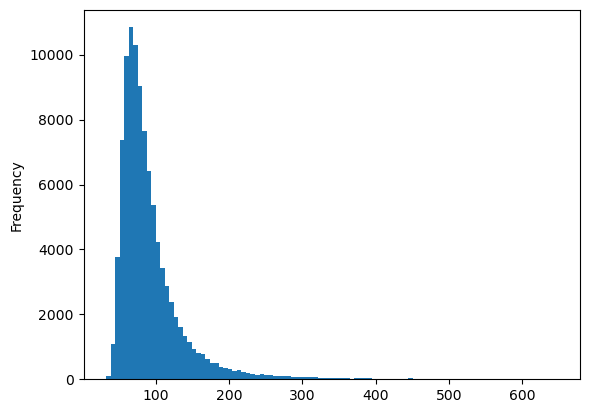

In [10]:
df['Price'].plot.hist(bins=100)


## Inputs and Fair Price Probability 


In [11]:
quants = df.quantile([i / 20 for i in range(1, 20)])
styled_df(quants)

,Growth,Cost of Capital,Price
0.050000,0.35%,4.45%,$50.86
0.100000,0.71%,4.80%,$55.21
0.150000,0.95%,5.04%,$58.71
0.200000,1.15%,5.23%,$61.79
0.250000,1.31%,5.39%,$64.59
0.300000,1.46%,5.54%,$67.44
0.350000,1.61%,5.68%,$70.25
0.400000,1.73%,5.81%,$73.17
0.450000,1.86%,5.93%,$76.27
0.500000,1.99%,6.06%,$79.65


## Plots of Inputs vs. Fair Price 


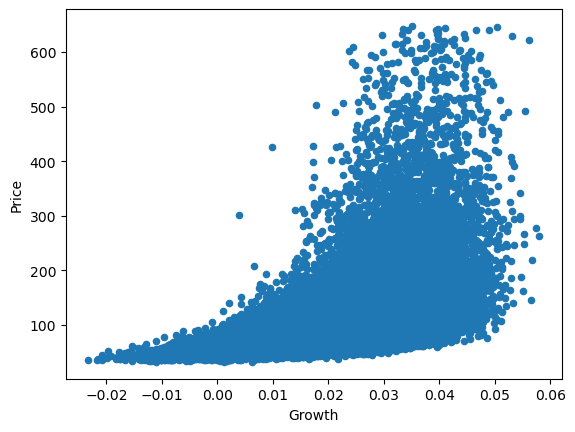

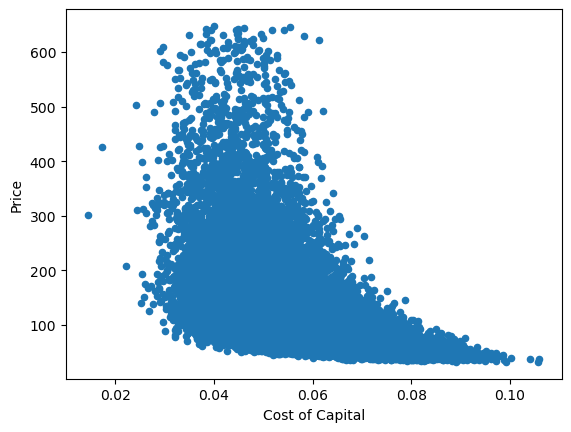

In [12]:

input_cols = [
    'Growth', 
    'Cost of Capital',
]

for col in input_cols:
    df.plot.scatter(y='Price', x=col)